# Lab 3 "Visual Listening In" Replication Study
MSBC 5190 "Modern Artificial Intelligence" Spring 2022

In this lab, we will replicate "Visual Listening In: Extracting Brand Image Portrayed on Social Media" (Liu et al. 2020).

This lab consists of two parts:

**Part I: Train a multi-label image classification model to classify images to brand attributes**
- Load and prepare data
- Build and train a model with transfer learning
- Choose best model snapshot and evaluate model performance

**Part II: Apply the model to Instagram photos and measure brand perceptions portrayed on consumer-generated images on social media**
- Load and prepare Instagram data
- Calculate image-based brand perception metrics
- Compare image-based brand perception metrics with survey-based brand perception metrics



In [1]:
from keras.applications.resnet import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import roc_auc_score

In [ ]:
# We define a function to draw learning curves. The function takes an instance
# of History as input and draw learning curves.
# More about History: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
def plot_learning_curve(history, epoch):
  plt.plot(history.history['accuracy'][:epoch])
  plt.plot(history.history['val_accuracy'][:epoch])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'][:epoch])
  plt.plot(history.history['val_loss'][:epoch])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Data Preparation

First, please click the following two links and copy them to your Google Drive
- Flickr data set (images): https://drive.google.com/file/d/10aOlEz3XOCPnnxV7rQ1DPjo-DmeH-DQL/view?usp=sharing
- Instagram data set (images): - https://drive.google.com/file/d/1ga90iTUgqFrZGCKO7O435spO3QcxRPP-/view?usp=

Please upload the following csv files from Canvas to this colab session
- flickr_data_labels.csv
- beverage_consumer.csv
- beverage_survey_instagram.csv

Next, we will mount Google Drive so that Google Colab can access files in your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TODO(YOU): Fill in where you kept the above files on Google Drive
google_drive_folder = '/content/drive/MyDrive/MSBC5190/'

In [ ]:
# Check what files are in this folder
!ls $google_drive_folder

consumer_beverage.zip	Flickr.zip
flickr_all_256_256.zip	instagram_user_256_256.zip
flickr_data_labels.csv	instagram_user_beverage_256_256.zip


In [ ]:
flickr_data_path = google_drive_folder +'flickr_all_256_256.zip'
instagram_data_path = google_drive_folder + 'consumer_beverage.zip'
print(flickr_data_path)
print(instagram_data_path)

/content/drive/MyDrive/MSBC5190/flickr_all_256_256.zip
/content/drive/MyDrive/MSBC5190/consumer_beverage.zip


In [ ]:
# Unzip the flickr image data to local directory
# You will see a folder named flickr_all_256_256 on the file explorer pane
!unzip $flickr_data_path

In [ ]:
# Count number of files in the flickr data set
# We have a total of 16360 images
!ls ./flickr_all_256_256/ | wc -l

16360


In [ ]:
# Unzip the Instagram data to local directory.
# You will see a folder named consumer_beverage on the file explorer pane
!unzip $instagram_data_path

In [ ]:
# List the folder consumer_beverage. There are 27 subfolders with 
# consumer-generated images from 27 brands
!ls ./consumer_beverage

bacardi    coorslight	gatorade     lipton	    nesquik	   vitaminwater
bigelow    corona	greygoose    minutemaid     sanpellegrino  welchs
budlight   domperignon	honesttea    moetchandon    snapple
budweiser  drpepper	jackdaniels  monsterenergy  swissmiss
cocacola   fanta	korbel	     motts	    tazo


## Part I: Train a multi-label image classification model to classify images to brand attributes



### Load and Prepare Data

We use ImageDataGenerator to load images on the fly from disks. Note that we are going to do multi-label image classification. We use function flow_from_dataframe() to set up data and lables. 

A good tutorial on multi-label classification with Keras ImageDataGenerator: https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

In [ ]:
# Read flickr data lable file
df = pd.read_csv('flickr_data_labels.csv')
columns = ['glamorous', 'rugged', 'healthy', 'fun']

# https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=datagen.flow_from_dataframe(
    # we use the first 13088 (i.e., 80%) images for training
    dataframe=df[:13088],    
    directory="./flickr_all_256_256",
    x_col="file_name",
    y_col=columns,
    batch_size=64,
    seed=42,
    shuffle=False,
    class_mode="raw",
    target_size=(224,224))

valid_generator=test_datagen.flow_from_dataframe(
    # the next 1360 (i.e., 10%) images for validation
    dataframe=df[13088:14724],
    directory="./flickr_all_256_256",
    x_col="file_name",
    y_col=columns,
    batch_size=64,
    seed=42,
    shuffle=False,
    class_mode="raw",
    target_size=(224,224))

test_generator=test_datagen.flow_from_dataframe(
    # the last 1360 (i.e., 10%) images for testing
    dataframe=df[14724:],
    directory="./flickr_all_256_256",
    x_col="file_name",
    y_col=columns,
    batch_size=64,
    seed=42,
    shuffle=False,
    class_mode="raw",
    target_size=(224,224))

Found 13088 validated image filenames.
Found 1636 validated image filenames.
Found 1636 validated image filenames.


### Build and train a multi-label image classification model with transfer learning



Load the pre-trained ResNet50 model


In [ ]:
resnet50 = ResNet50(weights="imagenet", 
                    include_top=False,
                    input_shape=(224, 224,3),
                    pooling=False)

94781440/94765736 [==============================] - 1s 0us/step


Freeze all the layers in the base ResNet50 model

In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

Add custom classification layer

In [ ]:
# Instantiate the sequential model and add the ResNet50 model: 
model = Sequential()
model.add(resnet50)

# Add the custom layers atop the VGG19 model: 
model.add(Flatten(name='flattened'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# We predict glamorous, rugged, health, fun
model.add(Dense(4, activation='sigmoid', name='predictions'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flattened (Flatten)         (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 predictions (Dense)         (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________


Configure and train model

In [ ]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Create callback to save trained model
checkpoint_filepath = 'resnet50.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n / train_generator.batch_size, 
                    validation_data=valid_generator, 
                    validation_steps=valid_generator.n / valid_generator.batch_size,
                    epochs=10,
                    verbose=1, 
                    shuffle=True,
                    callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
204/204 [==============================] - 53s 201ms/step - loss: 0.4835 - accuracy: 0.3520 - val_loss: 0.2996 - val_accuracy: 0.4370
Epoch 2/10
204/204 [==============================] - 39s 192ms/step - loss: 0.3169 - accuracy: 0.4278 - val_loss: 0.2816 - val_accuracy: 0.4279
Epoch 3/10
204/204 [==============================] - 39s 190ms/step - loss: 0.2768 - accuracy: 0.4574 - val_loss: 0.2744 - val_accuracy: 0.4468
Epoch 4/10
204/204 [==============================] - 39s 189ms/step - loss: 0.2527 - accuracy: 0.4788 - val_loss: 0.2681 - val_accuracy: 0.4480
Epoch 5/10
204/204 [==============================] - 39s 191ms/step - loss: 0.2325 - accuracy: 0.4978 - val_loss: 0.2655 - val_accuracy: 0.4633
Epoch 6/10
204/204 [==============================] - 38s 187ms/step - loss: 0.2154 - accuracy: 0.5131 - val_loss: 0.2627 - val_accuracy: 0.4682
Epoch 7/10
204/204 [==============================] - 38s 186ms/step - loss: 0.1987 - accuracy: 0.5275 - val_loss: 0.2635 - val_ac

Plot learning curves

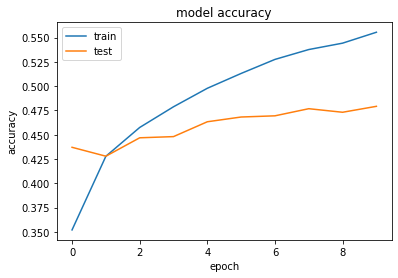

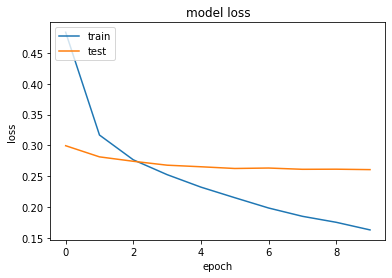

In [ ]:
plot_learning_curve(history, 10)

### Evaluate model performance on test data

Load the best model

In [ ]:
#model.load_weights('/tmp/resnet50.epoch10-loss0.26.hdf5')

In [ ]:
# Use the evaluate() function
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator,
                                          steps=test_generator.n/test_generator.batch_size,
                                          verbose=1) 

25/25 [==============================] - 4s 163ms/step - loss: 0.2796 - accuracy: 0.4719


In [ ]:
# Make predictions on test data
test_generator.reset()
test_pred_t = model.predict_generator(test_generator,
                                      steps=test_generator.n/test_generator.batch_size,
                                      verbose=1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


25/25 [==============================] - 5s 165ms/step


In [ ]:
# Convert probabilities to binary predictions
test_pred_bool = (test_pred_t > 0.5)
test_label_bool = df[14724:][columns].to_numpy()
# Calculate accuracy and AUC metrics for each brand attribute word
from sklearn.metrics import accuracy_score
for i in range(4):
  print('%s: Accuracy = %.2f, AUC = %.2f' % (columns[i],  
                                            accuracy_score(test_label_bool[:,i], test_pred_bool[:, i]),
                                            roc_auc_score(test_label_bool[:,i], test_pred_t[:, i])))

glamorous: Accuracy = 0.89, AUC = 0.86
rugged: Accuracy = 0.91, AUC = 0.87
healthy: Accuracy = 0.90, AUC = 0.86
fun: Accuracy = 0.90, AUC = 0.80


## Part II: Application to Instagram photos

In this section, we will apply the model trained in the previous section on Instagram photos and predict whether they are glamorous, rugged, healthy, and fun. For simplicity, we will only play with consumer-generated brand photos in the beverage category. There are 27 brands in total.

### Load brand image data and make predictions

In [ ]:
# For each brand, we use ImageDataGenerator to load images and then apply our
# model to make predictions. 
instagram_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# https://kylewbanks.com/blog/loading-unlabeled-images-with-imagedatagenerator-flowfromdirectory-keras
brand_score_list = []
brand_name_list = []
for brand in os.listdir('./consumer_beverage'):
  instagram_generator=instagram_datagen.flow_from_directory(
    directory='./consumer_beverage',
    classes=[brand],
    batch_size=64,
    seed=42,
    shuffle=False,
    target_size=(224,224))
  brand_pred_t = model.predict_generator(instagram_generator,
                                         steps=instagram_generator.n/instagram_generator.batch_size,
                                         verbose=0)
  # print(brand, np.mean(brand_pred_t, axis=0))
  brand_name_list.append(brand)
  # Calculate the average probability of brand photos that express each brand
  # attribute. This is our image-based brand perception metric.
  brand_score_list.append(np.mean(brand_pred_t, axis=0))

Found 2384 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Found 2352 images belonging to 1 classes.
Found 2357 images belonging to 1 classes.
Found 2283 images belonging to 1 classes.
Found 2398 images belonging to 1 classes.
Found 2314 images belonging to 1 classes.
Found 2337 images belonging to 1 classes.
Found 2381 images belonging to 1 classes.
Found 2292 images belonging to 1 classes.
Found 2341 images belonging to 1 classes.
Found 2377 images belonging to 1 classes.
Found 2375 images belonging to 1 classes.
Found 2298 images belonging to 1 classes.
Found 2317 images belonging to 1 classes.
Found 2312 images belonging to 1 classes.
Found 2281 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
Found 2347 images belonging to 1 classes.
Found 2307 images belonging to 1 classes.
Found 2387 images belonging to 1 classes.
Found 2307 images belonging to 1 classes.
Found 2296 images belonging to 1 classes.
Found 2340 images belonging to 1 classes.
Found 2159 images belonging to 1 classes.
Found 2298 images belonging to 1 c

### Calculate correlations between different brand perception metrics

In [ ]:
# Create a dataframe with brands and their image-based brand perception scores
brand_score_array = np.array(brand_score_list)
brand_perception_instagram = pd.DataFrame({'Brand': brand_name_list,
                                           'glamorous': brand_score_array[:, 0],
                                           'rugged': brand_score_array[:, 1],
                                           'healthy': brand_score_array[:, 2],
                                           'fun': brand_score_array[:, 3]})
# Order by brand names alphabetically
brand_perception_instagram = brand_perception_instagram.sort_values(by=['Brand'], 
                                                                    ignore_index=True)

In [ ]:
# Read brand perception metrics based on survey
brand_perception_survey = pd.read_csv('beverage_survey_instagram.csv')
# Read brand perception metrics computed in the original paper
brand_perception_paper = pd.read_csv('beverage_consumer.csv')

In [ ]:
brand_perception_instagram

,Brand,glamorous,rugged,healthy,fun
0,bacardi,0.087733,0.031439,0.309874,0.103604
1,bigelow,0.046243,0.039961,0.344399,0.055149
2,budlight,0.096298,0.056344,0.223565,0.136724
3,budweiser,0.084689,0.045170,0.236877,0.121908
4,cocacola,0.089444,0.042939,0.265310,0.106480
5,coorslight,0.116636,0.061500,0.209966,0.119251
6,corona,0.123920,0.042982,0.235848,0.108700
7,domperignon,0.113884,0.033888,0.212903,0.142427
8,drpepper,0.096275,0.036946,0.275506,0.100499
9,fanta,0.070427,0.029802,0.287779,0.123999


In [ ]:
brand_perception_paper

,brand,glamorous,rugged,healthy,fun
0,Bacardi,0.118285,0.058012,0.349244,0.176283
1,Bigelow's Tea,0.077316,0.054958,0.455015,0.111937
2,Bud Light,0.130493,0.082501,0.277892,0.223090
3,Budweiser,0.130183,0.082592,0.288670,0.195185
4,Coca-Cola,0.124415,0.076014,0.310544,0.181357
5,Coors Light,0.158098,0.092987,0.260990,0.200491
6,Corona,0.154895,0.068983,0.300454,0.182415
7,Dom Perignon,0.161818,0.074016,0.248047,0.216531
8,Dr Pepper,0.138315,0.063841,0.307093,0.180929
9,Fanta,0.105775,0.047418,0.338166,0.225250


In [ ]:
brand_perception_survey

,brand,total_count,glamorous,rugged,healthy,fun,Unnamed: 6,Unnamed: 7
0,Bacardi,158,0.189873,0.177215,0.075949,0.550633,NaN,NaN
1,Bigelow's Tea,128,0.085938,0.117188,0.632812,0.226562,NaN,NaN
2,Bud Light,158,0.075949,0.284810,0.082278,0.436709,NaN,NaN
3,Budweiser,158,0.113924,0.322785,0.088608,0.360759,NaN,NaN
4,Coca-Cola,171,0.152047,0.181287,0.064327,0.654971,NaN,NaN
5,Coors Light,152,0.065789,0.296053,0.125000,0.407895,NaN,NaN
6,Corona,157,0.127389,0.254777,0.063694,0.503185,NaN,NaN
7,Dom Perignon,133,0.503759,0.135338,0.090226,0.248120,NaN,NaN
8,Dr Pepper,163,0.128834,0.104294,0.128834,0.582822,NaN,NaN
9,Fanta,165,0.096970,0.066667,0.127273,0.654545,NaN,NaN


Calculate correlations between image-based metrics calculated in this replication study and those calculated in the orignial paper. They should have very high correlation.

In [ ]:
import scipy
for attribute in ['glamorous', 'rugged', 'healthy', 'fun']:
  p_value, corr = scipy.stats.pearsonr(brand_perception_instagram[attribute],
                                       brand_perception_paper[attribute])
  print('%s: corr = %.2f, p_value = %f' % (attribute, p_value, corr))

glamorous: corr = 0.98, p_value = 0.000000
rugged: corr = 0.92, p_value = 0.000000
healthy: corr = 0.95, p_value = 0.000000
fun: corr = 0.97, p_value = 0.000000


Calculate correlations between image-based metrics calculated in this replication study and those from a consumer survey. The numbers should be similar to Table 6 (Beverage category)



In [ ]:
for attribute in ['glamorous', 'rugged', 'healthy', 'fun']:
  p_value, corr = scipy.stats.pearsonr(brand_perception_instagram[attribute],
                                       brand_perception_survey[attribute])
  print('%s: corr = %.2f, p_value = %f' % (attribute, p_value, corr))

glamorous: corr = 0.43, p_value = 0.023491
rugged: corr = 0.70, p_value = 0.000043
healthy: corr = 0.73, p_value = 0.000013
fun: corr = 0.12, p_value = 0.537770
